-----------------
                                                      PowerCo SME Churn Analysis Project
                                                              Import Libraries
-----------------

In [1]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import datetime as dt
import warnings

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# --- Display Settings ---
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# --- Sklearn: Preprocessing, Splitting & Scaling ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

# --- Sklearn: Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    ExtraTreesClassifier, HistGradientBoostingClassifier
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# --- Sklearn: Feature Selection ---
from sklearn.feature_selection import RFE

# --- Sklearn: Metrics ---
from sklearn.metrics import (
    classification_report, confusion_matrix, balanced_accuracy_score,
    recall_score, roc_auc_score, precision_recall_curve, auc,
    f1_score, precision_score, average_precision_score,
    mean_squared_error, mean_absolute_error, roc_curve
)

# --- Statistical Tests ---
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Serialization ---
from pickle import dump, load

# --- Warning Settings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)


# PowerCo Churn Analysis Overview

## Overview

This project analyzes customer churn behavior for PowerCo, an energy and power provider. The goal is to identify key factors driving customer attrition and to build predictive models that help PowerCo proactively retain at-risk clients. The analysis focuses on energy consumption, pricing, and customer engagement patterns.

Data provided by PowerCo (synthetic data for analytical purposes). The analysis is conducted using Python — leveraging **pandas**, **scikit-learn**, **matplotlib**, and **RandomForest** for data cleaning, visualization, and predictive modeling.

This dataset originates from the **BCG Data Science Job Simulation on Forage (August 2025)**, where I obtained a completion certificate. I further refined and expanded the dataset to make the analysis more engaging and impactful.

## Datasets

Two datasets were used in this analysis:

### 1. `client_data.csv`

Contains client-level information, including energy and gas consumption, margins, product activity, contract details, and churn status.

**Key fields:**

* `id`: Client company identifier
* `activity_new`: Category of the company’s activity
* `channel_sales`: Code of the sales channel
* `cons_12m`: Electricity consumption over the past 12 months
* `cons_gas_12m`: Gas consumption over the past 12 months
* `cons_last_month`: Electricity consumption for the last month
* `date_activ`: Contract activation date
* `date_end`: Registered end date of the contract
* `forecast_cons_12m`: Forecasted consumption for the next 12 months
* `margin_net_pow_ele`: Net margin on power subscription
* `has_gas`: Indicates if the client also uses gas
* `churn`: Binary indicator for churn (1 = churned, 0 = retained)

### 2. `price_data.csv`

Provides time-based pricing information linked by client ID.

**Key fields:**

* `id`: Client company identifier
* `price_date`: Reference date
* `price_off_peak_var`: Energy price for off-peak period
* `price_peak_var`: Energy price for peak period
* `price_mid_peak_var`: Energy price for mid-peak period
* `price_off_peak_fix`: Power price for off-peak period
* `price_peak_fix`: Power price for peak period
* `price_mid_peak_fix`: Power price for mid-peak period

Some fields contain hashed text strings to preserve client privacy while retaining predictive meaning.


----------
                                                                Import Data
----------

In [2]:
# Load  dataset components
clientdf = pd.read_csv('client_data.csv')
pricedf = pd.read_csv('price_data.csv')

In [3]:
# Preview dataset structures - clientdf
print("=== Dataset Previews ===")

print("\nClient Data (First 5 rows):")
clientdf.head()

=== Dataset Previews ===

Client Data (First 5 rows):


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


In [4]:
# Preview dataset structures - pricedf
print("=== Dataset Previews ===")

print("\nPrice Data (First 5 rows):")
pricedf.head()

=== Dataset Previews ===

Price Data (First 5 rows):


,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


------------
                                                            Descriptive Statistic
------------

In [5]:

# Summary of the dataset - clientdf
print("\nclientdf Overview:")
print("Shape of data", clientdf.shape)
print("Unique value counts:")
print(clientdf.nunique())


clientdf Overview:
Shape of data (14606, 26)
Unique value counts:
id                                14606
channel_sales                         8
cons_12m                          11065
cons_gas_12m                       2112
cons_last_month                    4751
date_activ                         1796
date_end                            368
date_modif_prod                    2129
date_renewal                        386
forecast_cons_12m                 13993
forecast_cons_year                 4218
forecast_discount_energy             12
forecast_meter_rent_12m            3528
forecast_price_energy_off_peak      516
forecast_price_energy_peak          329
forecast_price_pow_off_peak          41
has_gas                               2
imp_cons                           7752
margin_gross_pow_ele               2391
margin_net_pow_ele                 2391
nb_prod_act                          10
net_margin                        11965
num_years_antig                      13
origin_up    

In [6]:
# Summary of the dataset - pricedf
print("\npricedf Overview:")
print("Shape of data", pricedf.shape)
print("Unique value counts:")
print(pricedf.nunique())


pricedf Overview:
Shape of data (193002, 8)
Unique value counts:
id                    16096
price_date               12
price_off_peak_var     1853
price_peak_var         1189
price_mid_peak_var      711
price_off_peak_fix       66
price_peak_fix           31
price_mid_peak_fix       28
dtype: int64


In [7]:
# the types of data - clientdf
clientdf.info()

# the types of data - pricedf
pricedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [8]:
# Check for missing entries - clientdf
missing = clientdf.isnull().mean().sort_values(ascending=False)
print(missing.head(27))

id                                0.0
channel_sales                     0.0
pow_max                           0.0
origin_up                         0.0
num_years_antig                   0.0
net_margin                        0.0
nb_prod_act                       0.0
margin_net_pow_ele                0.0
margin_gross_pow_ele              0.0
imp_cons                          0.0
has_gas                           0.0
forecast_price_pow_off_peak       0.0
forecast_price_energy_peak        0.0
forecast_price_energy_off_peak    0.0
forecast_meter_rent_12m           0.0
forecast_discount_energy          0.0
forecast_cons_year                0.0
forecast_cons_12m                 0.0
date_renewal                      0.0
date_modif_prod                   0.0
date_end                          0.0
date_activ                        0.0
cons_last_month                   0.0
cons_gas_12m                      0.0
cons_12m                          0.0
churn                             0.0
dtype: float

In [9]:
# Statistical summary of numerical features - clientdf
clientdf.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


In [10]:
# Statistical summary of categorical features - clientdf
clientdf.describe(include='object')

,id,channel_sales,date_activ,date_end,date_modif_prod,date_renewal,has_gas,origin_up
count,14606,14606,14606,14606,14606,14606,14606,14606
unique,14606,8,1796,368,2129,386,2,6
top,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,2009-08-01,2016-02-01,2015-11-01,2015-06-23,f,lxidpiddsbxsbosboudacockeimpuepw
freq,1,6754,95,145,721,587,11955,7097


In [11]:
# Statistical summary of numerical features - pricedf
pricedf.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [12]:
# Statistical summary of categorical features - pricedf
pricedf.describe(include='object')

,id,price_date
count,193002,193002
unique,16096,12
top,038af19179925da21a25619c5a24b745,2015-08-01
freq,12,16094


In [13]:
# Identify and count duplicate rows - clientdf
dups = clientdf.duplicated()
print("Number of duplicate rows - clientdf: ", dups.sum())

# Identify and count duplicate rows - pricedf
dups = pricedf.duplicated()
print("Number of duplicate rows - pricedf: ", dups.sum())

Number of duplicate rows - clientdf:  0
Number of duplicate rows - pricedf:  0


In [14]:
# Distribution of target variable
print(clientdf['churn'].value_counts())

# Distribution of target variable
clientdf['churn'].value_counts(normalize = True)*100

churn
0    13187
1     1419
Name: count, dtype: int64


churn
0    90.284814
1     9.715186
Name: proportion, dtype: float64

-----------------
                                                            Data Wrangling
-----------------

In [15]:
# split id to keep first seven characters - clientdf
clientdf['id'] = clientdf['id'].str[:7]
clientdf.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c5,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [16]:
# split id to keep first seven characters - clientdf
pricedf['id'] = pricedf['id'].str[:7]
pricedf.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [17]:
# convert object column to datetime - clientdf
clientdf["date_activ"] =pd.to_datetime(clientdf["date_activ"])
clientdf["date_end"] =pd.to_datetime(clientdf["date_end"])
clientdf["date_modif_prod"] =pd.to_datetime(clientdf["date_modif_prod"])
clientdf["date_renewal"] =pd.to_datetime(clientdf["date_renewal"])

# convert object column to datetime - clientdf
pricedf["price_date"] =pd.to_datetime(pricedf["price_date"])

In [18]:
# replace specific values in the column - clientdf
clientdf['channel_sales'] = clientdf['channel_sales'].replace({'foosdfpfkusacimwkcsosbicdxkicaua' : 'channel_sales_1','MISSING' : 'not_specified'})
clientdf['channel_sales'] = clientdf['channel_sales'].replace({'lmkebamcaaclubfxadlmueccxoimlema' : 'channel_sales_2','usilxuppasemubllopkaafesmlibmsdf' : 'channel_sales_3'})
clientdf['channel_sales'] = clientdf['channel_sales'].replace({'ewpakwlliwisiwduibdlfmalxowmwpci' : 'channel_sales_4','sddiedcslfslkckwlfkdpoeeailfpeds' : 'channel_sales_5'})
clientdf['channel_sales'] = clientdf['channel_sales'].replace({'epumfxlbckeskwekxbiuasklxalciiuu' : 'channel_sales_6','fixdbufsefwooaasfcxdxadsiekoceaa' : 'channel_sales_7'})

# Distribution of channel_sales variable
print(clientdf['channel_sales'].value_counts())

channel_sales
channel_sales_1    6754
not_specified      3725
channel_sales_2    1843
channel_sales_3    1375
channel_sales_4     893
channel_sales_5      11
channel_sales_6       3
channel_sales_7       2
Name: count, dtype: int64


In [19]:
# replace specific values in the column - clientdf
clientdf['has_gas'] = clientdf['has_gas'].replace({'f' : 'false','t' : 'true'})

# Distribution of has_gas variable
print(clientdf['has_gas'].value_counts())

has_gas
false    11955
true      2651
Name: count, dtype: int64


In [20]:
# replace specific values in the column - clientdf
clientdf['origin_up'] = clientdf['origin_up'].replace({'lxidpiddsbxsbosboudacockeimpuepw' : 'code_1','kamkkxfxxuwbdslkwifmmcsiusiuosws' : 'code_2'})
clientdf['origin_up'] = clientdf['origin_up'].replace({'ldkssxwpmemidmecebumciepifcamkci' : 'code_3','MISSING' : 'not_specified'})
clientdf['origin_up'] = clientdf['origin_up'].replace({'usapbepcfoloekilkwsdiboslwaxobdp' : 'code_4','ewxeelcelemmiwuafmddpobolfuxioce' : 'code_5'})

# Distribution of origin_up variable
print(clientdf['origin_up'].value_counts())

origin_up
code_1           7097
code_2           4294
code_3           3148
not_specified      64
code_4              2
code_5              1
Name: count, dtype: int64


In [21]:
# add new column - tenure
clientdf['tenure'] = clientdf['date_end'].dt.year-clientdf['date_activ'].dt.year

In [22]:
# replace specific values in the column - clientdf
clientdf['churn'] = clientdf['churn'].replace({ 0  : 'retention', 1 : 'churn'})

# Distribution of churn variable
print(clientdf['churn'].value_counts())

churn
retention    13187
churn         1419
Name: count, dtype: int64


In [23]:
# groupby id ,calculate average 
pricedf = pricedf.groupby('id',as_index = False)[['price_off_peak_var','price_peak_var','price_mid_peak_var','price_off_peak_fix','price_peak_fix','price_mid_peak_fix']].mean()
pricedf.head()

,id,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,0002203,0.124338,0.103794,0.073160,40.701732,24.421038,16.280694
1,0004351,0.146426,0.000000,0.000000,44.385450,0.000000,0.000000
2,0010bcc,0.181558,0.000000,0.000000,45.319710,0.000000,0.000000
3,0010ee3,0.118757,0.098292,0.069032,40.647427,24.388455,16.258971
4,00114d7,0.147926,0.000000,0.000000,44.266930,0.000000,0.000000


--------------
                                                    Merge Data (clientdf & pricedf)
--------------

In [24]:
# Merge datasets into unified dataframe
print("Merging datasets...")

df = clientdf.merge(pricedf, on="id", how="inner", validate='one_to_one')
print(f"Merged dataset shape: {df.shape}")
df.head()


Merging datasets...
Merged dataset shape: (14606, 33)


,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae,channel_sales_1,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,true,0.00,25.44,25.44,2,678.99,3,code_1,43.648,churn,3,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340
1,d29c2c5,not_specified,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,false,0.00,16.38,16.38,1,18.89,6,code_2,13.800,retention,7,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000
2,764c75f,channel_sales_1,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,false,0.00,28.60,28.60,1,6.60,6,code_2,13.856,retention,6,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000
3,bba0343,channel_sales_2,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,false,0.00,30.22,30.22,1,25.46,6,code_2,13.200,retention,6,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000
4,149d57c,not_specified,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,false,52.32,44.91,44.91,1,47.98,6,code_2,19.800,retention,6,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263


----------------------------------
                                                             Exploratory Data Analysis
----------------------------------

In [25]:

print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Distribution analysis
print("\n1. channel_sales Status Distribution:")
print(df['channel_sales'].value_counts())

print("\n2. has_gas Level Distribution:")
print(df['has_gas'].value_counts())

print("\n3. nb_prod_act Status Distribution:")
print(df['nb_prod_act'].value_counts())

print("\n4. num_years_antig Status Distribution:")
print(df['num_years_antig'].value_counts())

print("\n5. origin_up Status Distribution:")
print(df['origin_up'].value_counts())

print("\n5. tenure Status:")
print(df['tenure'].value_counts())

print("\n6. churn Distribution:")
print(df['churn'].value_counts())

EXPLORATORY DATA ANALYSIS

1. channel_sales Status Distribution:
channel_sales
channel_sales_1    6754
not_specified      3725
channel_sales_2    1843
channel_sales_3    1375
channel_sales_4     893
channel_sales_5      11
channel_sales_6       3
channel_sales_7       2
Name: count, dtype: int64

2. has_gas Level Distribution:
has_gas
false    11955
true      2651
Name: count, dtype: int64

3. nb_prod_act Status Distribution:
nb_prod_act
1     11431
2      2445
3       523
4       150
5        31
9        11
6         8
8         4
10        2
32        1
Name: count, dtype: int64

4. num_years_antig Status Distribution:
num_years_antig
6     4769
4     3982
3     2433
5     2317
7      509
11     185
12     110
8      103
9       92
10      81
13      13
2       11
1        1
Name: count, dtype: int64

5. origin_up Status Distribution:
origin_up
code_1           7097
code_2           4294
code_3           3148
not_specified      64
code_4              2
code_5              1
Name: cou

In [26]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Comparative analysis
print("\n1. Forecast Energy Consumption by Churn Status:")
forecast_energy_consumption_comparison = df.groupby('churn')[
    ["forecast_cons_12m", "forecast_cons_year"]
].mean().round(2)
forecast_energy_consumption_comparison

EXPLORATORY DATA ANALYSIS

1. Forecast Energy Consumption by Churn Status:


,forecast_cons_12m,forecast_cons_year
churn,,
churn,1962.86,1374.44
retention,1858.47,1402.49


In [27]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Comparative analysis
print("\n2. Forecast Price Energy by Churn Status:")
forecast_price_energy_comparison = df.groupby('churn')[
    ["forecast_price_energy_off_peak", "forecast_price_energy_peak", "forecast_price_pow_off_peak", "forecast_discount_energy"]
].mean().round(2)
forecast_price_energy_comparison 

EXPLORATORY DATA ANALYSIS

2. Forecast Price Energy by Churn Status:


,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,forecast_discount_energy
churn,,,,
churn,0.14,0.05,43.33,1.23
retention,0.14,0.05,43.11,0.94


In [28]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Comparative analysis
print("\n3.  Price of Power by Churn Status:")
price_of_power_comparison = df.groupby('churn')[
    ["price_off_peak_fix", "price_peak_fix", "price_mid_peak_fix"]
].mean().round(2)
price_of_power_comparison 

EXPLORATORY DATA ANALYSIS

3.  Price of Power by Churn Status:


,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
churn,,,
churn,43.16,11.20,7.16
retention,42.90,9.27,5.98


In [29]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Comparative analysis
print("\n4.  Price of Energy by Churn Status:")
price_of_energy_comparison = df.groupby('churn')[
    ["price_off_peak_var", "price_peak_var", "price_mid_peak_var"]
].mean().round(2)
price_of_energy_comparison 

EXPLORATORY DATA ANALYSIS

4.  Price of Energy by Churn Status:


,price_off_peak_var,price_peak_var,price_mid_peak_var
churn,,,
churn,0.14,0.06,0.03
retention,0.14,0.05,0.03


In [30]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# net_margin Comparison by has_gas and churn Status
print("\n5. net_margin Comparison by has_gas and churn Status:")
print("True:")
print(df.query("has_gas == 'true'").groupby("churn")["net_margin"].mean().round(2))

print("\nFalse:")
print(df.query("has_gas == 'false'").groupby("churn")["net_margin"].mean().round(2))

EXPLORATORY DATA ANALYSIS

5. net_margin Comparison by has_gas and churn Status:
True:
churn
churn        417.64
retention    233.78
Name: net_margin, dtype: float64

False:
churn
churn        194.19
retention    174.03
Name: net_margin, dtype: float64


In [31]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# pow_max Comparison by has_gas and churn Status
print("\n6. pow_max Comparison by has_gas and churn Status:")
print("True:")
print(df.query("has_gas == 'true'").groupby("churn")["pow_max"].mean().round(2))

print("\nFalse:")
print(df.query("has_gas == 'false'").groupby("churn")["pow_max"].mean().round(2))

EXPLORATORY DATA ANALYSIS

6. pow_max Comparison by has_gas and churn Status:
True:
churn
churn        21.82
retention    19.44
Name: pow_max, dtype: float64

False:
churn
churn        18.95
retention    17.67
Name: pow_max, dtype: float64


--------------------------------------
                                                             DATA VISUALIZATION
--------------------------------------


Generating visualizations...


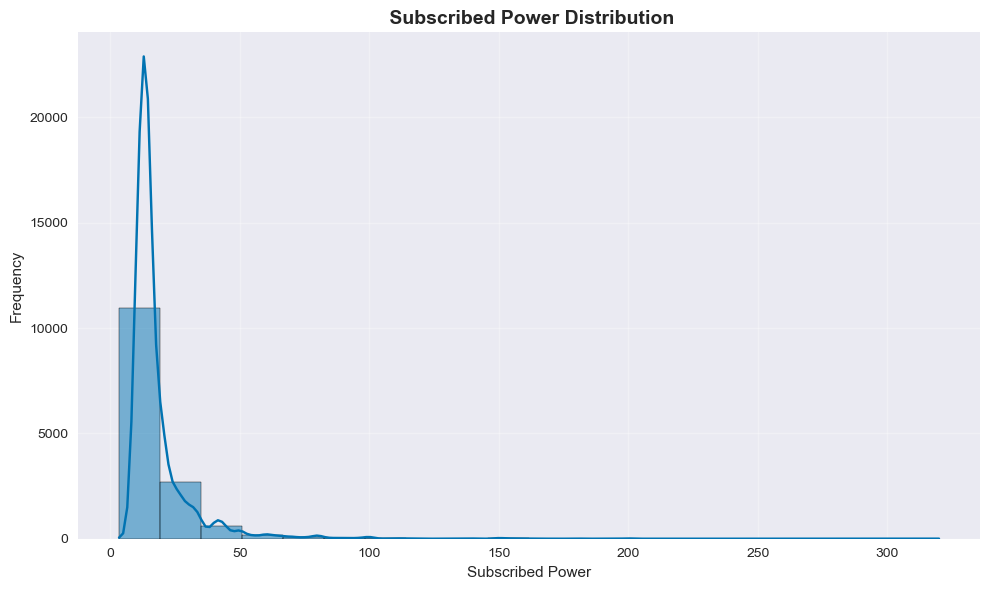

In [32]:
print("\nGenerating visualizations...")

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("colorblind")

# Figure 1: Subscribed Power Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['pow_max'], bins=20, kde=True)
plt.title(' Subscribed Power Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Subscribed Power')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

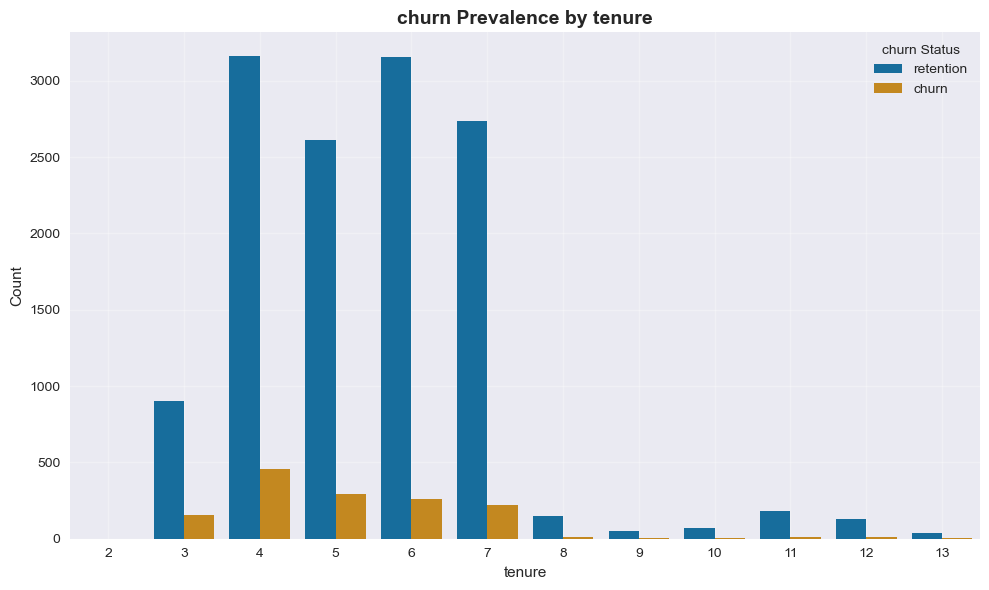

In [33]:
# Figure 2: churn by tenure
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='tenure', hue='churn')
plt.title('churn Prevalence by tenure', fontsize=14, fontweight='bold')
plt.xlabel('tenure')
plt.ylabel('Count')
plt.legend(title='churn Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

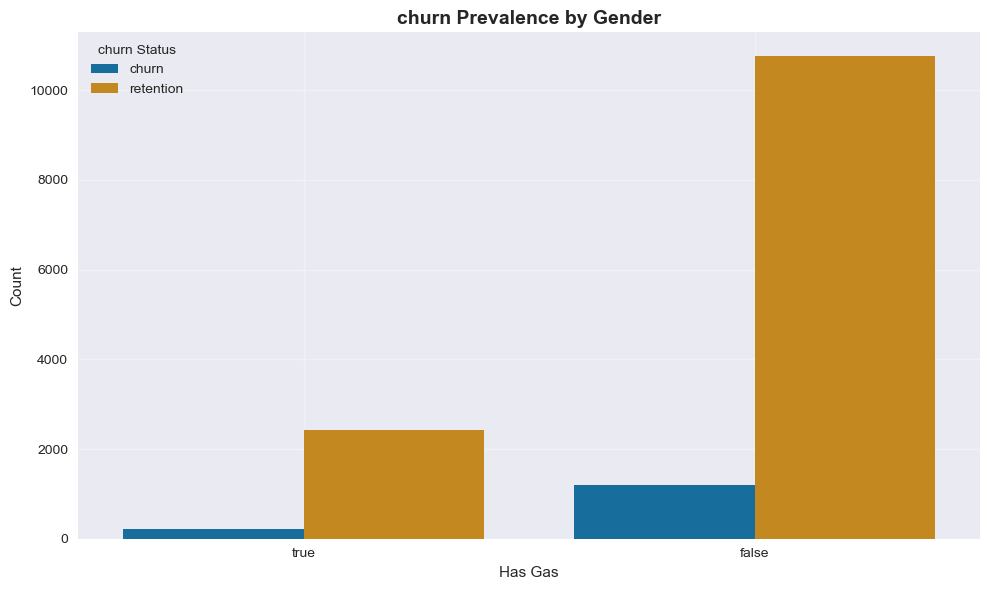

In [34]:
# Figure 3: churn by has_gas
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='has_gas', hue='churn')
plt.title('churn Prevalence by has_gas', fontsize=14, fontweight='bold')
plt.xlabel('Has Gas')
plt.ylabel('Count')
plt.legend(title='churn Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

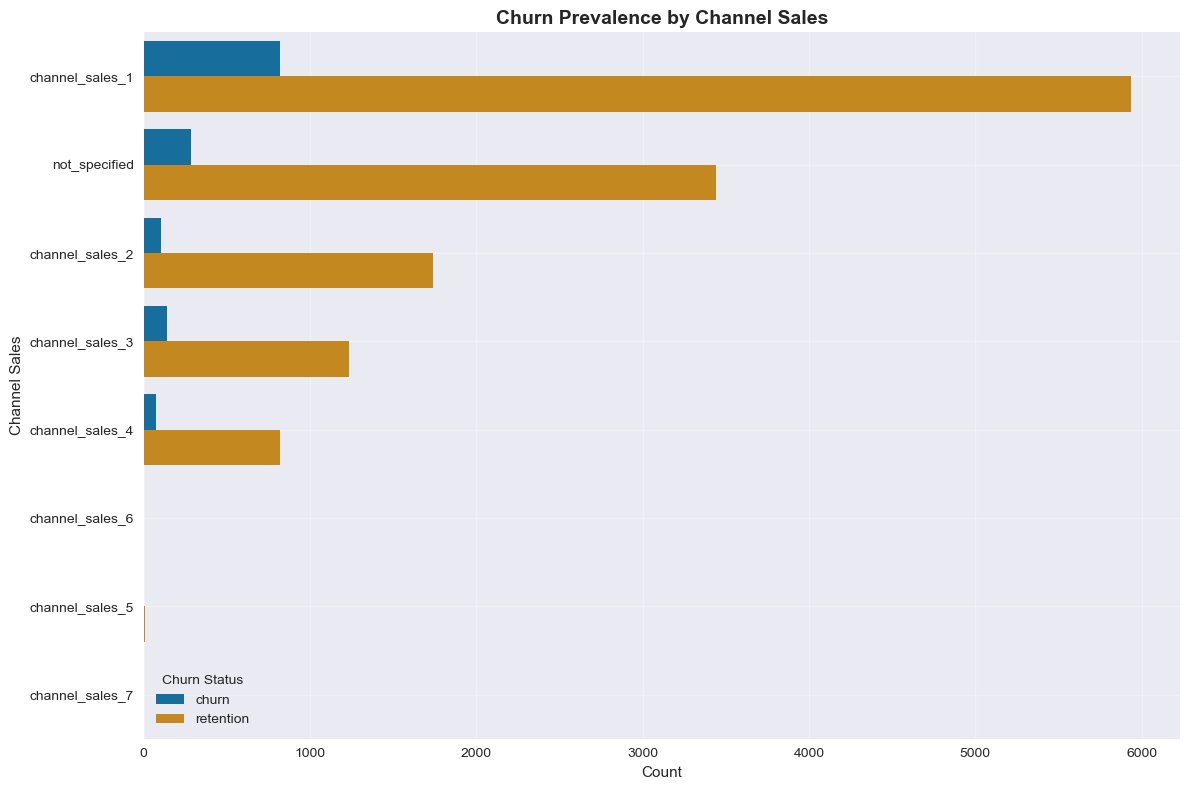

In [35]:
# Figure 4: Churn by Channel Sales
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='channel_sales', hue='churn')
plt.title('Churn Prevalence by Channel Sales', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Channel Sales')
plt.legend(title='Churn Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

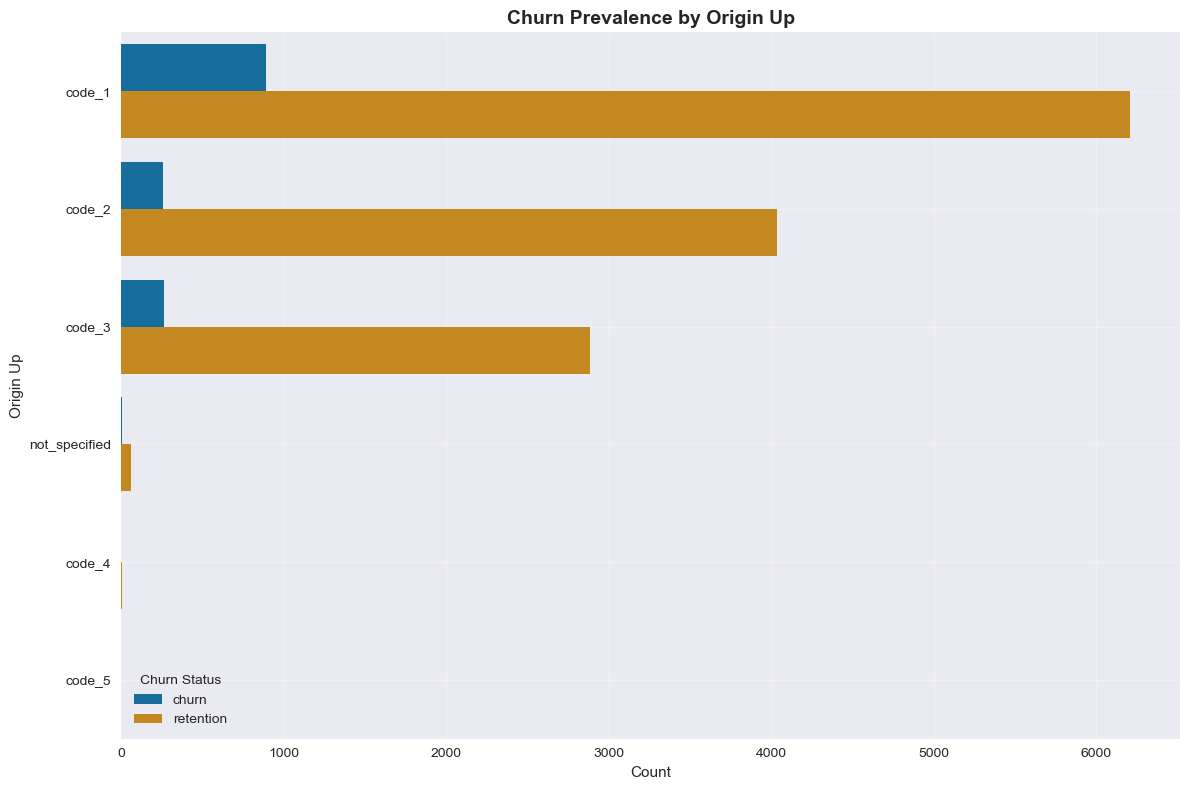

In [36]:
# Figure 5: Churn by Origin Up
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='origin_up', hue='churn')
plt.title('Churn Prevalence by Origin Up', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.ylabel('Origin Up')
plt.legend(title='Churn Status')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

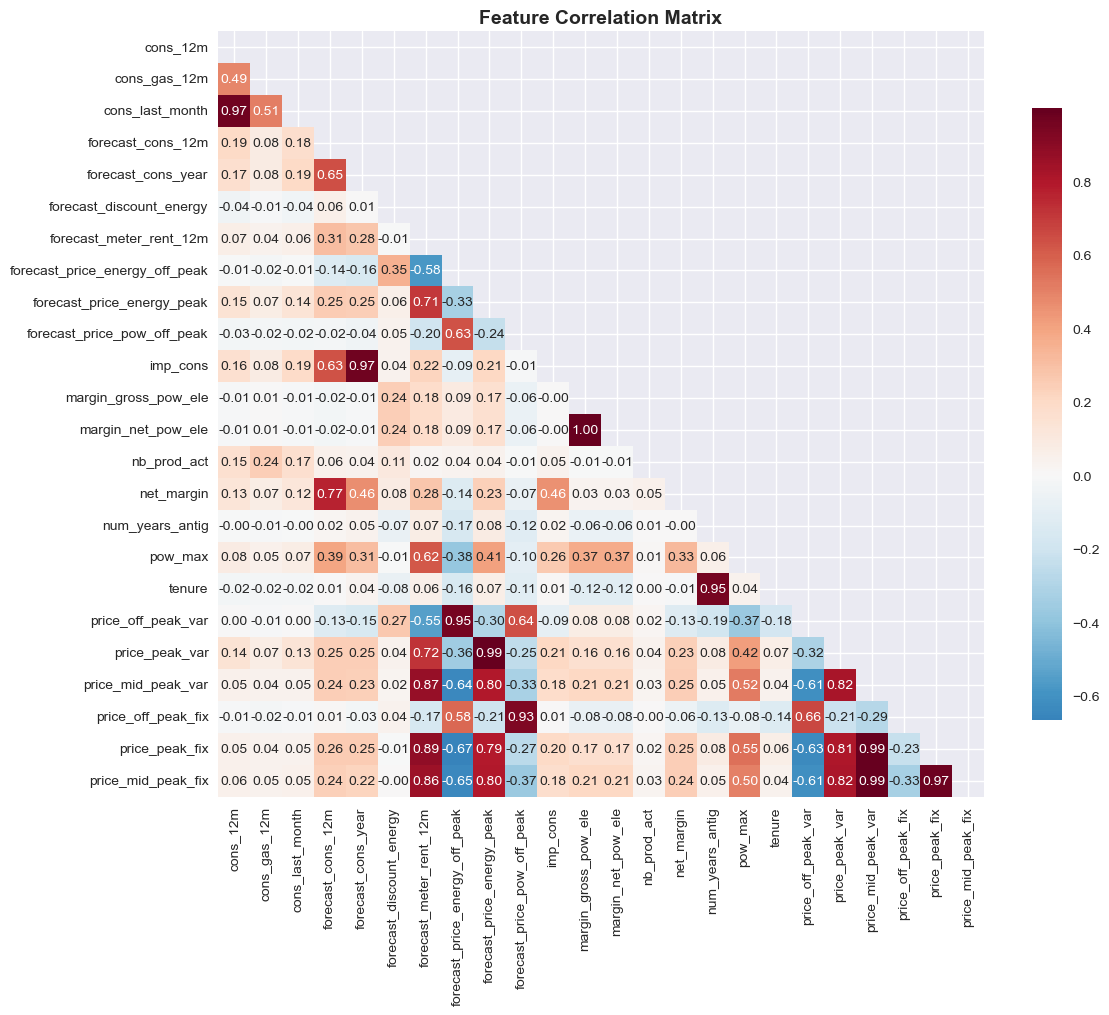

In [37]:
# Figure 6: Correlation Heatmap
plt.figure(figsize=(12, 10))
imputed_numeric_features = df.select_dtypes(['float64','int64','int32']).columns
imputed_numeric_features = imputed_numeric_features
correlation_matrix = df[imputed_numeric_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

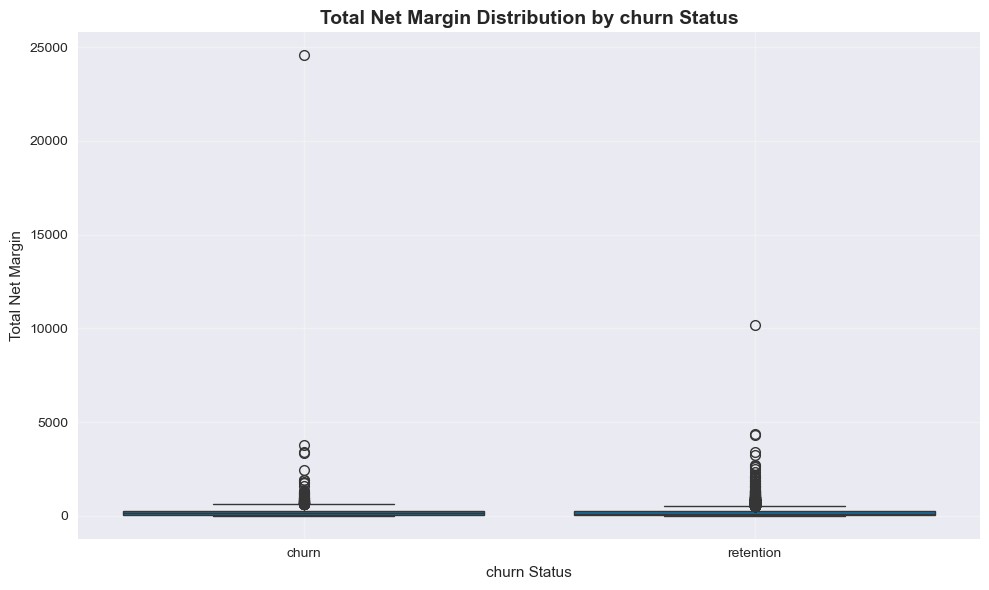

In [38]:
# Figure 7: Total Net Margin by Churn Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='net_margin', data=df)
plt.title('Total Net Margin Distribution by churn Status', fontsize=14, fontweight='bold')
plt.xlabel('churn Status')
plt.ylabel('Total Net Margin')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


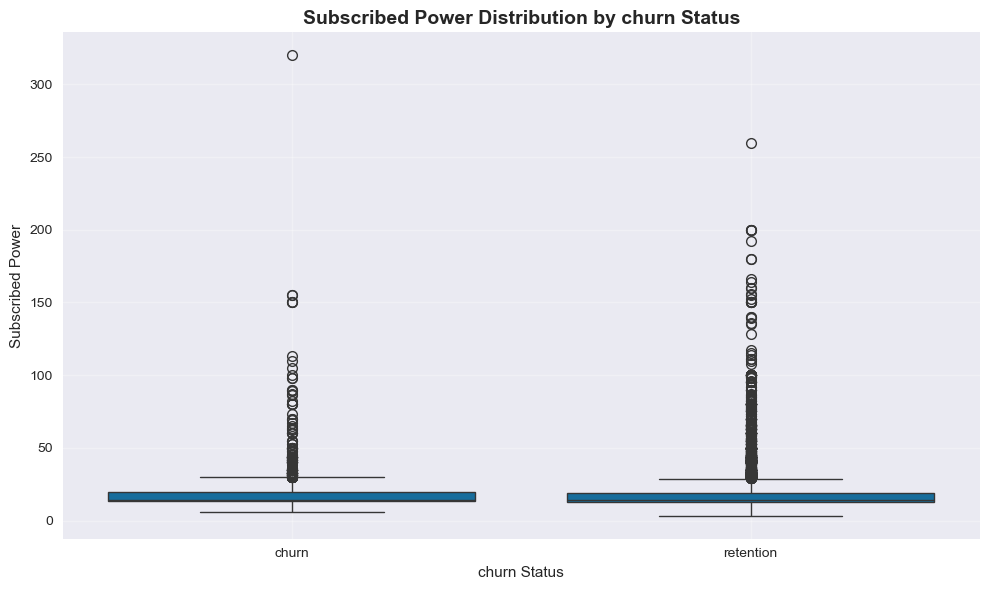

In [39]:
# Figure 8:  Subscribed Power by churn Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='pow_max', data=df)
plt.title('Subscribed Power Distribution by churn Status', fontsize=14, fontweight='bold')
plt.xlabel('churn Status')
plt.ylabel('Subscribed Power')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


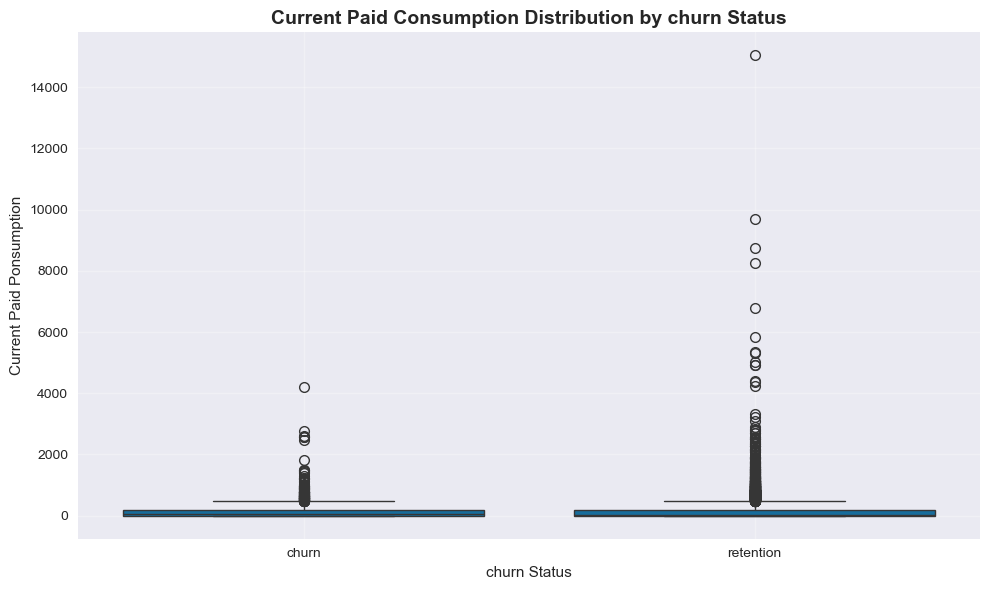

In [40]:
# Figure 9: Current Paid Consumption by churn Status
plt.figure(figsize=(10, 6))
sns.boxplot(x='churn', y='imp_cons', data=df)
plt.title('Current Paid Consumption Distribution by churn Status', fontsize=14, fontweight='bold')
plt.xlabel('churn Status')
plt.ylabel('Current Paid Ponsumption')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🔍 Exploratory Data Analysis (EDA) Insights

- **Churn Distribution:** Only about 10% of clients churned (1,419 out of 14,606), showing a strong class imbalance — an important point for modeling.  
- **Customer Channels:** Most customers belong to `channel_sales_1` and `not_specified`, suggesting limited diversity in acquisition channels.  
- **Gas Subscription:** Around 82% of clients don’t have gas service, indicating energy-only customers dominate.  
- **Tenure & Antiquity:** Majority of customers have been with PowerCo for 3–7 years, showing moderate loyalty levels.  
- **Products:** Most clients have one active product, with very few holding multiple products — potential for upselling opportunities.  
- **Origin Codes:** Codes `1`, `2`, and `3` represent nearly all customers, meaning other origin categories are negligible.  

### 💡 Key Numerical Insights

- **Energy Consumption:**  
  Churned clients show slightly **higher forecast consumption** than retained ones — may suggest high-usage customers are more price-sensitive.  
- **Energy Price:**  
  Price variation is fairly consistent across churn and retention groups, implying churn might not be directly price-driven.  
- **Net Margin:**  
  Churned customers (especially with gas) have **higher margins**, possibly due to premium plans or higher energy use.  
- **Power Usage:**  
  `pow_max` is higher among churned clients — they might be heavy energy users seeking cheaper alternatives.

### 📈 Correlation Highlights

- **Strong Positive Correlations:**
  - `cons_12m`, `cons_last_month`, and `forecast_cons_12m` → highly correlated (r > 0.9), showing consistency in energy usage trends.
  - `forecast_cons_year` and `imp_cons` → nearly perfect correlation (r ≈ 0.97), suggesting both capture similar annual consumption.
  - Price variables (e.g., `price_peak_fix`, `price_mid_peak_fix`, `price_off_peak_fix`) → strongly correlated (>0.97), indicating redundancy.

- **Moderate Positive Correlations:**
  - `net_margin` with `forecast_cons_12m` (r ≈ 0.77) — higher consumption often leads to higher margins.
  - `pow_max` correlates with `forecast_cons_12m` (r ≈ 0.39), reflecting that higher power capacity links to higher usage.

- **Recommendation:**  
  - Consider dropping or combining **highly correlated features** (to reduce multicollinearity).  
  - Explore **feature engineering** around `net_margin`, `pow_max`, and `forecast_cons_12m` — they seem most predictive.  
  - Since churn is imbalanced, apply **resampling or threshold tuning** to improve model sensitivity to minority (churn) class.


--------------------------------------
                                                        Save Processed Data
--------------------------------------

In [41]:
# Save the processed dataset
output_path = 'PowerCo_analysis.csv'
df.to_csv(output_path, index=False)
print(f"\nProcessed data saved to: {output_path}")
print(f"Final dataset shape: {df.shape}")


Processed data saved to: PowerCo_analysis.csv
Final dataset shape: (14606, 33)


---------------------
                                                    Final Summary Statistics
------------------------

In [42]:
# Final summary statistics
print("\n" + "="*60)
print("FINAL SUMMARY STATISTICS")
print("="*60)

print(f"\nTotal Participants: {len(df):,}")
print(f"Churn Cases: {df[df['churn'] == 'churn'].shape[0]:,}")
print(f"Non-Churn Cases: {df[df['churn'] == 'retention'].shape  [0]:,}")
print(f"Churn Prevalence: {(df['churn'] == 'churn').mean():.2%}")

print(f"\nHas Gas Individuals: {df[df['has_gas'] == 'true'].shape[0]:,}")
print(f"No Gas Individuals: {df[df['has_gas'] == 'false'].shape[0]:,}")

print(f"\nMax Active Product: {df['nb_prod_act'].max()}")
print(f"Max Number(Years): {df['num_years_antig'].max()}")

print(f"\nHighest Gross Margin: {df['margin_gross_pow_ele'].max()}")
print(f"Highest Total Net Margin : {df['net_margin'].max()}")


FINAL SUMMARY STATISTICS

Total Participants: 14,606
Churn Cases: 1,419
Non-Churn Cases: 13,187
Churn Prevalence: 9.72%

Has Gas Individuals: 2,651
No Gas Individuals: 11,955

Max Active Product: 32
Max Number(Years): 13

Highest Gross Margin: 374.64
Highest Total Net Margin : 24570.65


-----------------
                                                        Machine Learning
-----------------

In [43]:
# remove redundant column
cols = ['id','date_activ','date_end', 'date_modif_prod', 'date_renewal']
df = df.drop(columns=cols)
df.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,tenure,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,channel_sales_1,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,true,0.00,25.44,25.44,2,678.99,3,code_1,43.648,churn,3,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340
1,not_specified,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,false,0.00,16.38,16.38,1,18.89,6,code_2,13.800,retention,7,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000
2,channel_sales_1,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,false,0.00,28.60,28.60,1,6.60,6,code_2,13.856,retention,6,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000
3,channel_sales_2,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,false,0.00,30.22,30.22,1,25.46,6,code_2,13.200,retention,6,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000
4,not_specified,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,false,52.32,44.91,44.91,1,47.98,6,code_2,19.800,retention,6,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263


In [44]:
# Encode categorical variables using Label Encoding
le = LabelEncoder()
df['channel_sales'] = le.fit_transform(df['channel_sales'])
df['has_gas'] = le.fit_transform(df['has_gas'])
df['origin_up'] = le.fit_transform(df['origin_up'])

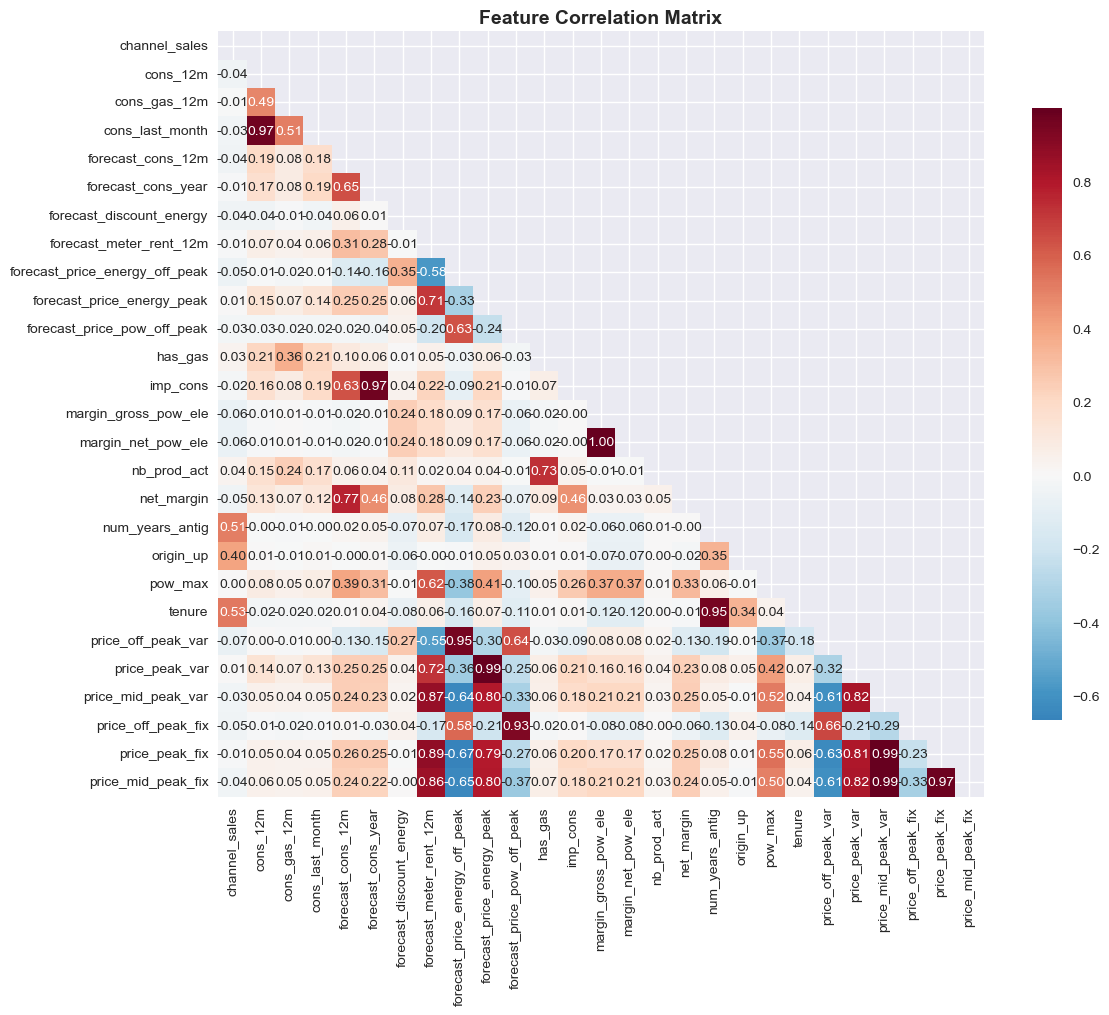

In [45]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
imputed_numeric_features = df.select_dtypes(['float64','int64','int32']).columns
imputed_numeric_features = imputed_numeric_features
correlation_matrix = df[imputed_numeric_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

-----------------------
                                                    Manual Removal of Columns using ViF
-----------------------

In [46]:

# Calculate VIF for each variable
vif = df[imputed_numeric_features]
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                           Feature           VIF
0                    channel_sales      2.488448
1                         cons_12m     18.324898
2                     cons_gas_12m      1.534132
3                  cons_last_month     18.468224
4                forecast_cons_12m      5.950531
5               forecast_cons_year     22.993282
6         forecast_discount_energy      2.488187
7          forecast_meter_rent_12m     10.229845
8   forecast_price_energy_off_peak   1040.689250
9       forecast_price_energy_peak    196.475483
10     forecast_price_pow_off_peak   1697.876913
11                         has_gas      2.887268
12                        imp_cons     22.118395
13            margin_gross_pow_ele  14480.971854
14              margin_net_pow_ele  14471.622059
15                     nb_prod_act      9.387716
16                      net_margin      3.490266
17                 num_years_antig    125.144660
18                       origin_up      2.246119
19                  

In [47]:
# drop column
vif = vif.drop(columns =('margin_gross_pow_ele'))

In [48]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                           Feature          VIF
0                    channel_sales     2.487981
1                         cons_12m    18.324892
2                     cons_gas_12m     1.534124
3                  cons_last_month    18.468208
4                forecast_cons_12m     5.949200
5               forecast_cons_year    22.993267
6         forecast_discount_energy     2.485253
7          forecast_meter_rent_12m    10.229842
8   forecast_price_energy_off_peak  1040.675869
9       forecast_price_energy_peak   196.472555
10     forecast_price_pow_off_peak  1697.862103
11                         has_gas     2.887136
12                        imp_cons    22.118386
13              margin_net_pow_ele     4.646422
14                     nb_prod_act     9.386479
15                      net_margin     3.489126
16                 num_years_antig   125.131611
17                       origin_up     2.245369
18                         pow_max     6.569336
19                          tenure   142

In [49]:
# drop column
vif = vif.drop(columns =('price_off_peak_fix'))

In [50]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                           Feature         VIF
0                    channel_sales    2.486949
1                         cons_12m   18.319691
2                     cons_gas_12m    1.534110
3                  cons_last_month   18.464384
4                forecast_cons_12m    5.894705
5               forecast_cons_year   22.861022
6         forecast_discount_energy    2.485249
7          forecast_meter_rent_12m   10.228173
8   forecast_price_energy_off_peak  716.045432
9       forecast_price_energy_peak  196.058040
10     forecast_price_pow_off_peak  605.395790
11                         has_gas    2.884590
12                        imp_cons   22.007728
13              margin_net_pow_ele    4.493078
14                     nb_prod_act    9.360961
15                      net_margin    3.464505
16                 num_years_antig  121.373380
17                       origin_up    2.242874
18                         pow_max    6.534936
19                          tenure  138.843047
20           

In [51]:
# drop column
vif = vif.drop(columns =('forecast_price_energy_off_peak'))

In [52]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                        Feature         VIF
0                 channel_sales    2.485676
1                      cons_12m   18.318455
2                  cons_gas_12m    1.534069
3               cons_last_month   18.463658
4             forecast_cons_12m    5.889458
5            forecast_cons_year   22.835815
6      forecast_discount_energy    1.593022
7       forecast_meter_rent_12m   10.228120
8    forecast_price_energy_peak  194.024458
9   forecast_price_pow_off_peak  387.164603
10                      has_gas    2.884053
11                     imp_cons   21.990577
12           margin_net_pow_ele    4.139801
13                  nb_prod_act    9.358399
14                   net_margin    3.453897
15              num_years_antig  121.372144
16                    origin_up    2.242306
17                      pow_max    6.384680
18                       tenure  138.786117
19           price_off_peak_var  362.245448
20               price_peak_var  226.448635
21           price_mid_peak_var 

In [53]:
# drop column
vif = vif.drop(columns =('forecast_price_pow_off_peak'))

In [54]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature         VIF
0                channel_sales    2.484162
1                     cons_12m   18.315426
2                 cons_gas_12m    1.533892
3              cons_last_month   18.461868
4            forecast_cons_12m    5.882139
5           forecast_cons_year   22.814243
6     forecast_discount_energy    1.288985
7      forecast_meter_rent_12m   10.226850
8   forecast_price_energy_peak  192.110439
9                      has_gas    2.871822
10                    imp_cons   21.975947
11          margin_net_pow_ele    4.000778
12                 nb_prod_act    9.270872
13                  net_margin    3.443101
14             num_years_antig  121.311264
15                   origin_up    2.240862
16                     pow_max    6.286684
17                      tenure  137.513283
18          price_off_peak_var   17.003401
19              price_peak_var  214.056351
20          price_mid_peak_var  255.602959
21              price_peak_fix   97.828283
22         

In [55]:
# drop column
vif = vif.drop(columns =('price_mid_peak_var'))

In [56]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature         VIF
0                channel_sales    2.483342
1                     cons_12m   18.306714
2                 cons_gas_12m    1.533772
3              cons_last_month   18.458964
4            forecast_cons_12m    5.875432
5           forecast_cons_year   22.751897
6     forecast_discount_energy    1.216563
7      forecast_meter_rent_12m   10.226566
8   forecast_price_energy_peak  191.992103
9                      has_gas    2.871821
10                    imp_cons   21.924535
11          margin_net_pow_ele    3.888615
12                 nb_prod_act    9.270827
13                  net_margin    3.423274
14             num_years_antig  120.807162
15                   origin_up    2.240568
16                     pow_max    6.216515
17                      tenure  137.168941
18          price_off_peak_var   16.999700
19              price_peak_var  213.530849
20              price_peak_fix   45.074286
21          price_mid_peak_fix   37.876656


In [57]:
# drop column
vif = vif.drop(columns =('price_peak_var'))

In [58]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature         VIF
0                channel_sales    2.482853
1                     cons_12m   18.300133
2                 cons_gas_12m    1.533763
3              cons_last_month   18.448478
4            forecast_cons_12m    5.871644
5           forecast_cons_year   22.714888
6     forecast_discount_energy    1.185976
7      forecast_meter_rent_12m   10.226021
8   forecast_price_energy_peak    6.493931
9                      has_gas    2.871476
10                    imp_cons   21.887184
11          margin_net_pow_ele    3.874129
12                 nb_prod_act    9.260518
13                  net_margin    3.423273
14             num_years_antig  120.792834
15                   origin_up    2.239665
16                     pow_max    6.216189
17                      tenure  137.077917
18          price_off_peak_var   16.653161
19              price_peak_fix   44.903824
20          price_mid_peak_fix   37.578148


In [59]:
# drop column
vif = vif.drop(columns =('tenure'))

In [60]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature        VIF
0                channel_sales   2.423281
1                     cons_12m  18.279547
2                 cons_gas_12m   1.532840
3              cons_last_month  18.443571
4            forecast_cons_12m   5.865835
5           forecast_cons_year  22.714279
6     forecast_discount_energy   1.185534
7      forecast_meter_rent_12m  10.225928
8   forecast_price_energy_peak   6.477873
9                      has_gas   2.870754
10                    imp_cons  21.885615
11          margin_net_pow_ele   3.688590
12                 nb_prod_act   9.259159
13                  net_margin   3.422733
14             num_years_antig  12.902637
15                   origin_up   2.238965
16                     pow_max   6.166753
17          price_off_peak_var  14.863250
18              price_peak_fix  44.788856
19          price_mid_peak_fix  37.243280


In [61]:
# drop column
vif = vif.drop(columns =('price_peak_fix'))

In [62]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature        VIF
0                channel_sales   2.421800
1                     cons_12m  18.267588
2                 cons_gas_12m   1.532831
3              cons_last_month  18.440528
4            forecast_cons_12m   5.858141
5           forecast_cons_year  22.511959
6     forecast_discount_energy   1.180522
7      forecast_meter_rent_12m   8.996888
8   forecast_price_energy_peak   6.400124
9                      has_gas   2.868977
10                    imp_cons  21.740430
11          margin_net_pow_ele   3.543501
12                 nb_prod_act   9.255254
13                  net_margin   3.422730
14             num_years_antig  12.845828
15                   origin_up   2.233889
16                     pow_max   5.929319
17          price_off_peak_var  14.614241
18          price_mid_peak_fix   9.522995


In [63]:
# drop column
vif = vif.drop(columns =('forecast_cons_year'))

In [64]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature        VIF
0                channel_sales   2.421759
1                     cons_12m  18.247870
2                 cons_gas_12m   1.532830
3              cons_last_month  18.410527
4            forecast_cons_12m   5.794052
5     forecast_discount_energy   1.174539
6      forecast_meter_rent_12m   8.989851
7   forecast_price_energy_peak   6.387351
8                      has_gas   2.866640
9                     imp_cons   2.121123
10          margin_net_pow_ele   3.527215
11                 nb_prod_act   9.253248
12                  net_margin   3.415938
13             num_years_antig  12.783728
14                   origin_up   2.233889
15                     pow_max   5.846800
16          price_off_peak_var  14.278303
17          price_mid_peak_fix   9.522994


In [65]:
# drop column
vif = vif.drop(columns =('cons_last_month'))

In [66]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature        VIF
0                channel_sales   2.419442
1                     cons_12m   1.508093
2                 cons_gas_12m   1.492754
3            forecast_cons_12m   5.724190
4     forecast_discount_energy   1.174519
5      forecast_meter_rent_12m   8.987345
6   forecast_price_energy_peak   6.385848
7                      has_gas   2.842420
8                     imp_cons   2.033684
9           margin_net_pow_ele   3.527214
10                 nb_prod_act   9.159759
11                  net_margin   3.415545
12             num_years_antig  12.775396
13                   origin_up   2.233857
14                     pow_max   5.846708
15          price_off_peak_var  14.253978
16          price_mid_peak_fix   9.521824


In [67]:
# drop column
vif = vif.drop(columns =('price_off_peak_var'))

In [68]:

# Calculate VIF for each variable
X = vif
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)

                       Feature       VIF
0                channel_sales  2.315701
1                     cons_12m  1.507710
2                 cons_gas_12m  1.492478
3            forecast_cons_12m  5.671673
4     forecast_discount_energy  1.172951
5      forecast_meter_rent_12m  8.984795
6   forecast_price_energy_peak  6.004024
7                      has_gas  2.636954
8                     imp_cons  2.029346
9           margin_net_pow_ele  3.144041
10                 nb_prod_act  7.087737
11                  net_margin  3.414589
12             num_years_antig  7.905685
13                   origin_up  2.229081
14                     pow_max  5.846678
15          price_mid_peak_fix  8.699070


-----------------------
                                                        Recheck Correlation
-----------------------

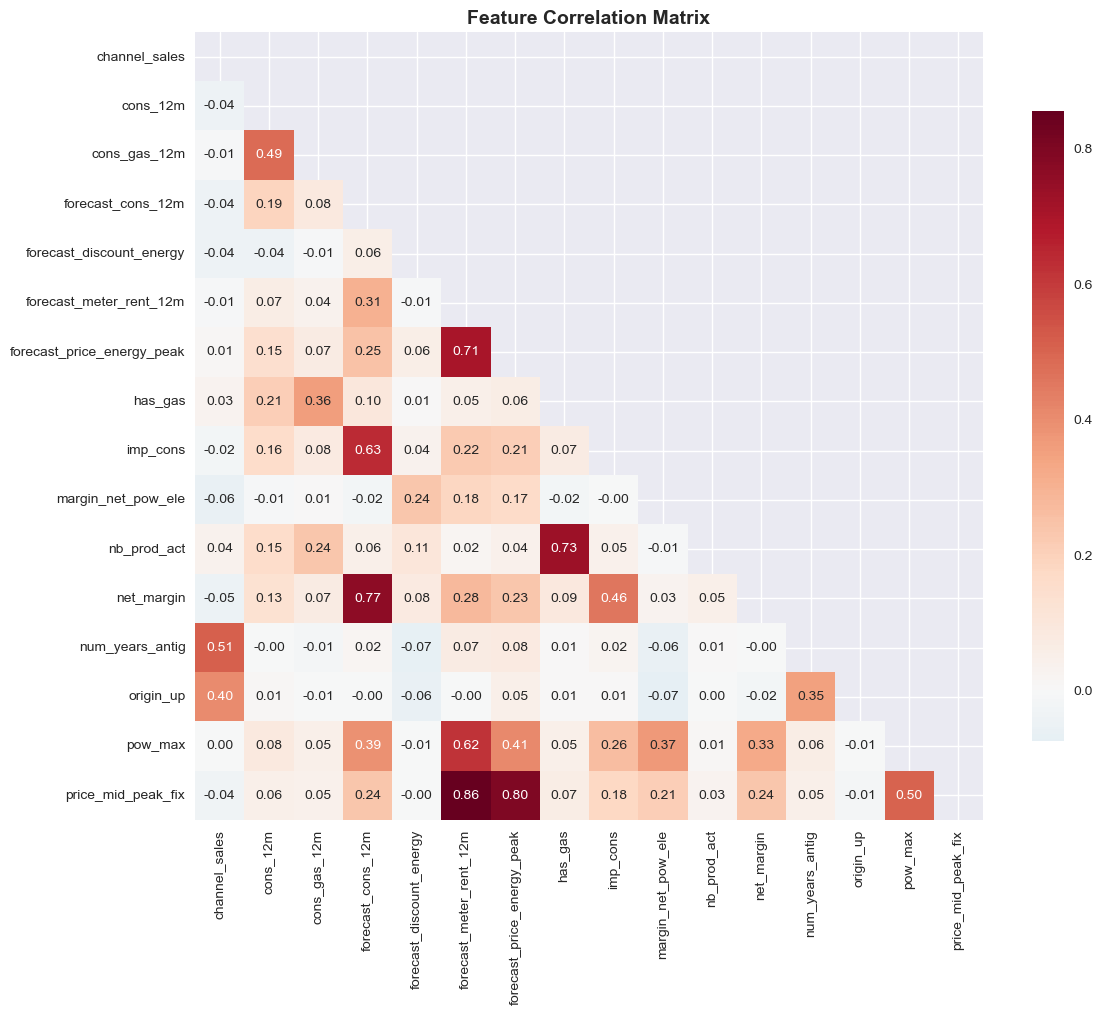

In [69]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
imputed_numeric_features = vif.select_dtypes(['float64','int64','int32']).columns
imputed_numeric_features = imputed_numeric_features
correlation_matrix = df[imputed_numeric_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [70]:
# join the column
df = vif.join(df['churn'])
df.head(5)

,channel_sales,cons_12m,cons_gas_12m,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_peak,has_gas,imp_cons,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,price_mid_peak_fix,churn
0,0,0,54946,0.00,0.0,1.78,0.098142,1,0.00,25.44,2,678.99,3,0,43.648,14.901340,churn
1,7,4660,0,189.95,0.0,16.27,0.000000,0,0.00,16.38,1,18.89,6,1,13.800,0.000000,retention
2,0,544,0,47.96,0.0,38.72,0.087899,0,0.00,28.60,1,6.60,6,1,13.856,0.000000,retention
3,1,1584,0,240.04,0.0,19.83,0.000000,0,0.00,30.22,1,25.46,6,1,13.200,0.000000,retention
4,7,4425,0,445.75,0.0,131.73,0.100015,0,52.32,44.91,1,47.98,6,1,19.800,16.275263,retention


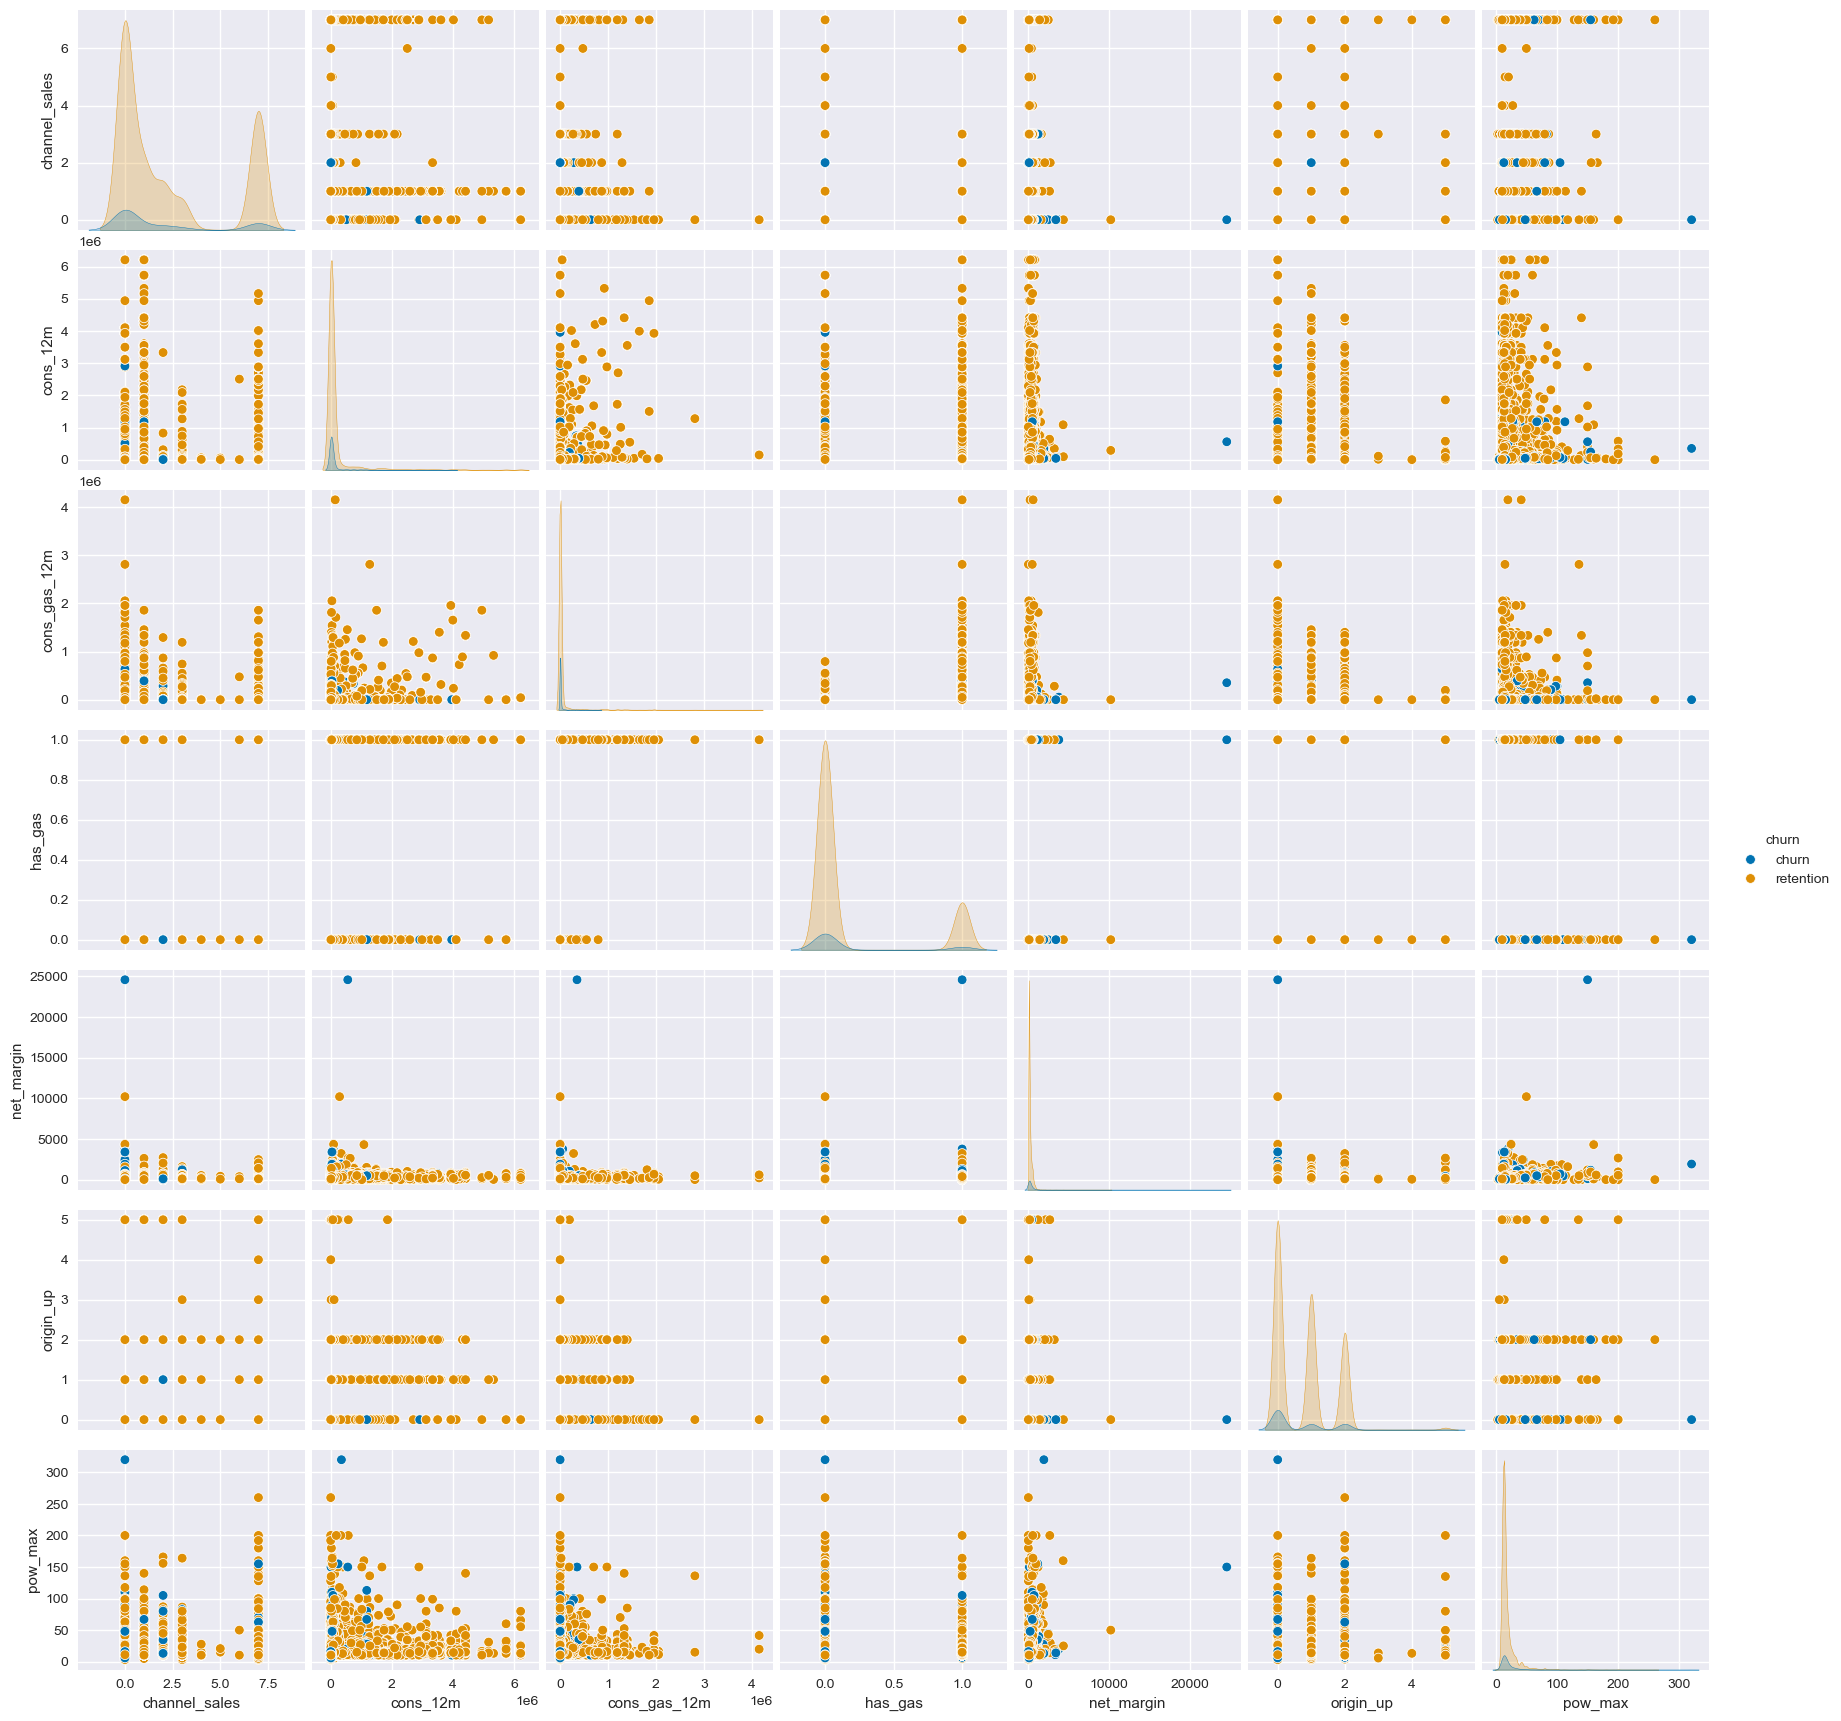

In [71]:
# Pairplot of key numeric features with churn status
num_features = ['channel_sales', 'cons_12m', 'cons_gas_12m', 'has_gas',
                'net_margin', 'origin_up', 'pow_max']
sns.pairplot(df[num_features + ['churn']], hue='churn')
plt.show()


------
                                                        Feature Importance
------

In [72]:
# Prepare features (X) and target (y)
X = df.drop(["churn"], axis=1)
y = df["churn"]

In [73]:


# Calculate feature importance using Random Forest
rf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
rf.fit(X, y)

feature_importances = pd.DataFrame({
    'features': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

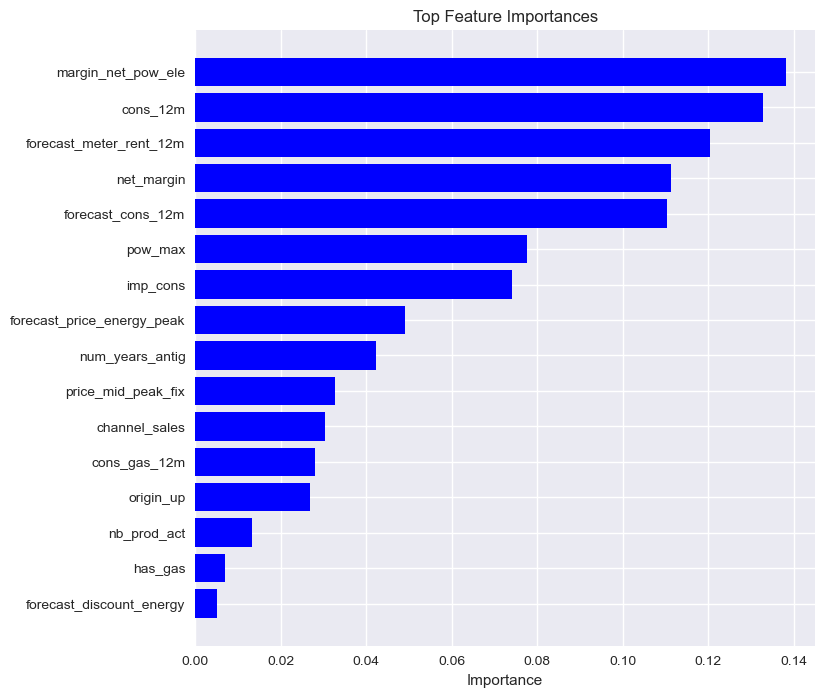

In [74]:


# Sort features by importance and plot top features
top_features = feature_importances.sort_values(by='importance', ascending=False)

plt.figure(figsize=(8, 8))
plt.barh(range(len(top_features)), top_features['importance'], color='b', align='center')
plt.yticks(range(len(top_features)), top_features['features'])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()  # Display highest importance on top
plt.show()

In [75]:
# feature Importance Scores
feature_importances

,index,features,importance
0,4,forecast_discount_energy,0.005234
1,7,has_gas,0.007094
2,10,nb_prod_act,0.013341
3,13,origin_up,0.026872
4,2,cons_gas_12m,0.028081
5,0,channel_sales,0.030427
6,15,price_mid_peak_fix,0.032729
7,12,num_years_antig,0.042236
8,6,forecast_price_energy_peak,0.049000
9,8,imp_cons,0.074096


### 🔍 Feature Selection & Interpretation — PowerCo Churn Analysis

**Model Used:**  
`RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")`

**Feature Selection Process:**
- **VIF Analysis:** Manually removed 10 highly correlated features (VIF > 10)
- **Correlation Handling:** Retained moderate correlations (0.80-0.86) for tree-based algorithms to process
- **Final Feature Set:** 16 optimized variables balancing stability and predictive power

**Key Insights:**

**Top 5 Churn Predictors:**
1. **margin_net_pow_ele** (0.138) - *Electricity profit margin*
2. **cons_12m** (0.133) - *12-month consumption history*  
3. **forecast_meter_rent_12m** (0.121) - *Projected meter rental revenue*
4. **net_margin** (0.111) - *Overall customer profitability*
5. **forecast_cons_12m** (0.110) - *Expected future consumption*

**Critical Business Findings:**
- **Financial health dominates** - Margin metrics are 3x more important than price sensitivity
- **Price variables largely irrelevant** - Most pricing features removed during VIF screening
- **Customer value over discounts** - `forecast_discount_energy` shows minimal impact (0.005)
- **Usage patterns matter** - Historical and forecasted consumption strongly predictive

**Missing Analysis & Recommendations:**

**Hybrid Approach Recommended:**
- **Combine financial and behavioral metrics** for segmentation
- **Add customer tenure analysis** - Was removed but may provide context
- **Incorporate price sensitivity scores** for high-value segments only

**Immediate Actions:**
- **Priority 1:** Protect high-margin customers (>0.138 importance)
- **Priority 2:** Monitor consumption drops in high-value clients
- **Priority 3:** Review meter rental pricing strategy

**Strategic Shifts:**
- Move from **price-based retention** to **value-based relationships**
- Focus on **usage pattern monitoring** as early warning system
- Develop **margin protection strategies** over discount campaigns

**Model Validation:**
- Tree-based approach effectively handled remaining correlations
- Feature importance aligns with business logic - increasing trustworthiness
- Consider testing with gradient boosting for comparison

*Note: While price sensitivity appears low, further segmentation analysis may reveal niche price-sensitive segments worth targeted approaches.*

--------
                                                        Save Processed Data
---------

In [76]:
# Save the processed dataset
output_path = 'PowerCo_ml.csv'
df.to_csv(output_path, index=False)
print(f"\nProcessed data saved to: {output_path}")
print(f"Final dataset shape: {df.shape}")


Processed data saved to: PowerCo_ml.csv
Final dataset shape: (14606, 17)


-----------------------
                                                        VALIDATION DATASET
-----------------------

In [77]:
# Prepare final features and target
X = df.drop(columns = ('churn'))
y = df["churn"]
# Encode target variable
y = y.map({'churn': 1, 'retention': 0})

In [78]:
# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Set evaluation parameters
num_folds = 3
seed = 42
scoring = 'average_precision'
shuffle = True

In [79]:
# Scale the features
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledValidationX = scaler.transform(X_test)



-------------------------------
                                                        ALGORITHM CLASSIFICATION
-------------------------------

In [80]:


# Evaluate baseline classification algorithms
models = []
models.append(('LR', LogisticRegression(class_weight="balanced",random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(class_weight="balanced",random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(class_weight="balanced",random_state=seed)))

results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.169631 (0.005216)
LDA: 0.168134 (0.006362)
KNN: 0.126096 (0.000453)
CART: 0.109359 (0.001594)
NB: 0.134346 (0.004138)
SVM: 0.173006 (0.006526)


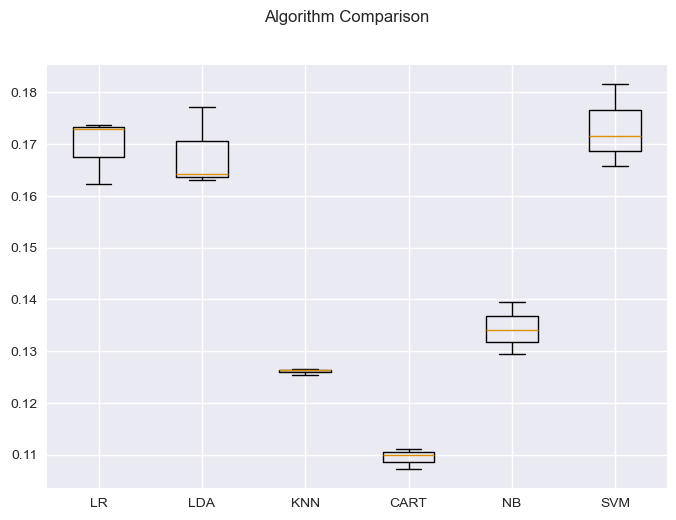

In [81]:
# Compare algorithm performance using box plots
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [82]:

# Evaluate ensemble algorithms
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(random_state=seed)))
ensembles.append(('GBM', GradientBoostingClassifier(random_state=seed)))
ensembles.append(('RF', RandomForestClassifier(class_weight="balanced",random_state=seed)))
ensembles.append(('ET', ExtraTreesClassifier(class_weight="balanced",random_state=seed)))
ensembles.append(('XGBC', XGBClassifier(random_state=seed)))
ensembles.append(('HGBC', HistGradientBoostingClassifier(class_weight="balanced",random_state=seed)))
ensembles.append(('LGBC', LGBMClassifier(class_weight="balanced",verbose=-1,random_state=seed)))


results = []
names = []
for name, model in ensembles:
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=shuffle, random_state=seed)
    cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.175562 (0.011820)
GBM: 0.185904 (0.003988)
RF: 0.221506 (0.016377)
ET: 0.204283 (0.018862)
XGBC: 0.199317 (0.009372)
HGBC: 0.201970 (0.005862)
LGBC: 0.204222 (0.010075)


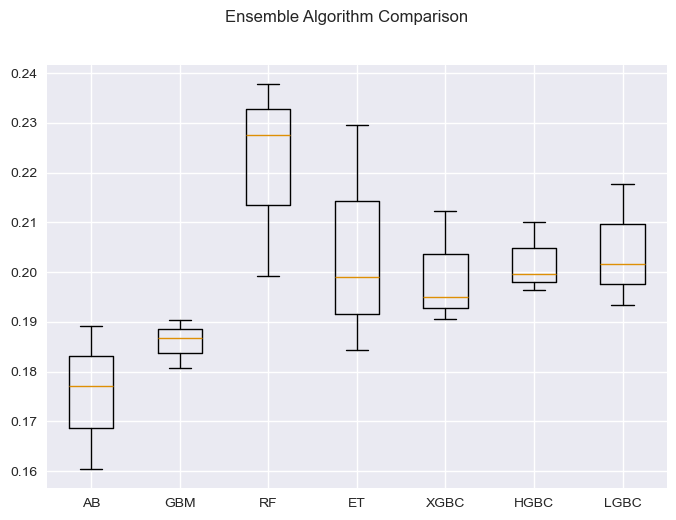

In [83]:
# Compare Ensemble performance using box plots
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

---------
                                     Random Forest Classifier: Grid Search for Hyperparameter Optimization
----------

### ⚙️ Model Training — PowerCo Churn Analysis

After comparing several ensemble algorithms, **Random Forest (RF)** consistently delivered the **best overall performance** and was selected for the final churn model training.

**Model Comparison (Average Precision Scores):**
- **RF (Random Forest): 0.2215 ± 0.0164** ✅ *(Best Performing Model)*
- GBM (Gradient Boosting): 0.1859 ± 0.0040  
- ET (Extra Trees): 0.2043 ± 0.0189  
- XGBC (XGBoost): 0.1993 ± 0.0094  
- HGBC (Histogram Gradient Boosting): 0.2020 ± 0.0059  
- LGBC (LightGBM): 0.2042 ± 0.0101  
- AB (AdaBoost): 0.1756 ± 0.0118  

**Why Random Forest Was Chosen:**
- Showed the **highest model stability and accuracy** across cross-validation folds.  
- Managed **imbalanced data** effectively using `class_weight='balanced'`.  
- Performed well without heavy feature scaling — ideal for mixed numeric and categorical data.  
- Balanced interpretability and performance compared to more complex models like XGBoost or LightGBM.  

**Model Explanation:**
- Random Forest belongs to the **ensemble** family — combining multiple Decision Trees trained on random subsets of data and features.  
- Instead of relying on a single tree (which might overfit), Random Forest aggregates many “weak learners” to form a strong, robust predictor.  
- The diversity among trees helps generalize better, following the principle that **many weak learners together form a powerful model**.  

**Advantages:**
- Handles **non-linear relationships** and feature interactions naturally.  
- No need for strict feature scaling or normalization.  
- Reduces overfitting through averaging (bagging) across multiple trees.

**Limitations:**
- Can be **computationally intensive** on large datasets.  
- Longer **training time** compared to single-tree models.  

**Summary Insight:**  
Random Forest outperformed other ensemble algorithms and emerged as the most reliable and interpretable model for predicting customer churn in PowerCo’s energy and pricing datasets. Its balanced trade-off between accuracy, robustness, and interpretability makes it the **recommended model for deployment and further tuning**.


In [84]:

# Tune Random Forest Classifier
n_estimators = [100, 200, 500,1000]
max_depth = [None,1, 3, 5, 7]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

model = RandomForestClassifier(random_state=seed, class_weight="balanced")
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.234820 using {'max_depth': None, 'n_estimators': 1000}
0.221506 (0.016377) with: {'max_depth': None, 'n_estimators': 100}
0.228943 (0.014544) with: {'max_depth': None, 'n_estimators': 200}
0.232356 (0.011842) with: {'max_depth': None, 'n_estimators': 500}
0.234820 (0.011533) with: {'max_depth': None, 'n_estimators': 1000}
0.168260 (0.008667) with: {'max_depth': 1, 'n_estimators': 100}
0.170500 (0.009141) with: {'max_depth': 1, 'n_estimators': 200}
0.171306 (0.008824) with: {'max_depth': 1, 'n_estimators': 500}
0.172535 (0.008144) with: {'max_depth': 1, 'n_estimators': 1000}
0.176145 (0.009890) with: {'max_depth': 3, 'n_estimators': 100}
0.174849 (0.009893) with: {'max_depth': 3, 'n_estimators': 200}
0.174306 (0.008117) with: {'max_depth': 3, 'n_estimators': 500}
0.174506 (0.008481) with: {'max_depth': 3, 'n_estimators': 1000}
0.188312 (0.007339) with: {'max_depth': 5, 'n_estimators': 100}
0.186437 (0.006246) with: {'max_depth': 5, 'n_estimators': 200}
0.183249 (0.005928) with: 

In [85]:


# Train Random Forest Classifier with optimal parameters
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    random_state=42,
    class_weight="balanced"
)
rf.fit(rescaledX, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42)

In [86]:

# Predict probabilities with Random Forest
y_proba = rf.predict_proba(rescaledValidationX)[:, 1]

In [87]:

# Calculate precision-recall metrics and find optimal threshold
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

f1_scores = 2 * (precisions[1:] * recalls[1:]) / (precisions[1:] + recalls[1:] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Average Precision (AUC-PR):", round(ap_score, 3))
print('---------------------')
print(f"Best Threshold : {best_threshold:.3f}")
print('---------------------')
print(f"Precision: {precisions[best_idx+1]:.3f}, Recall: {recalls[best_idx+1]:.3f}, F1 Score: {f1_scores[best_idx]:.3f}")
print('---------------------')



# Manual thresholds with step=0.05
manual_thresholds = np.arange(0.0, 1.0001, 0.025)  # include 1.0
rows = []
for t in manual_thresholds:
    y_pred = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred, zero_division=0)
    r = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    rows.append({
        "threshold": round(float(t), 2),
        "precision": p,
        "recall": r,
        "f1": f1
    })

df = pd.DataFrame(rows).loc[:, ["threshold", "precision", "recall", "f1"]]

# # === Print summary ===
# print(f"Overall Average Precision (AUC-PR): {ap_score:.4f}")
# print(f"Best threshold from precision_recall_curve (max F1): {best_threshold_pr:.4f} -> F1: {best_f1_pr:.4f}")
# print("\nF1 / Precision / Recall at manual thresholds (step=0.05):")
print(df.to_string(index=False))



Average Precision (AUC-PR): 0.258
---------------------
Best Threshold : 0.162
---------------------
Precision: 0.254, Recall: 0.387, F1 Score: 0.307
---------------------
 threshold  precision   recall       f1
      0.00   0.097194 1.000000 0.177168
      0.03   0.101656 0.929577 0.183270
      0.05   0.114730 0.830986 0.201623
      0.08   0.138211 0.718310 0.231818
      0.10   0.164751 0.605634 0.259036
      0.12   0.195739 0.517606 0.284058
      0.15   0.236791 0.426056 0.304403
      0.18   0.261580 0.338028 0.294931
      0.20   0.290909 0.281690 0.286225
      0.23   0.306931 0.218310 0.255144
      0.25   0.323944 0.161972 0.215962
      0.28   0.327103 0.123239 0.179028
      0.30   0.390244 0.112676 0.174863
      0.33   0.444444 0.098592 0.161383
      0.35   0.479167 0.080986 0.138554
      0.38   0.488372 0.073944 0.128440
      0.40   0.588235 0.070423 0.125786
      0.43   0.653846 0.059859 0.109677
      0.45   0.772727 0.059859 0.111111
      0.48   0.789474 0.0528

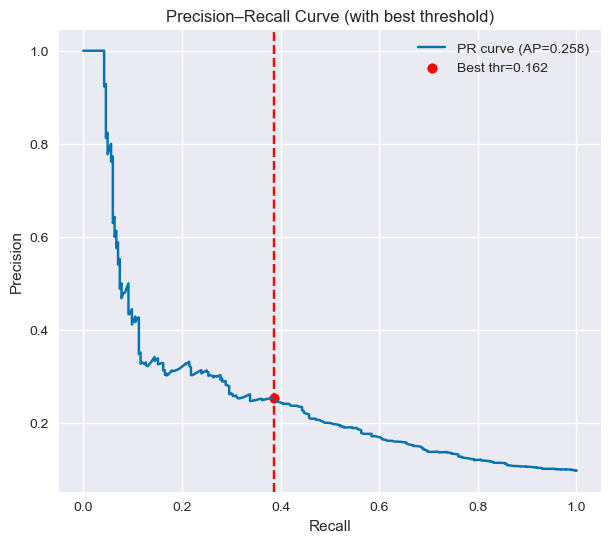

In [88]:


# Plot precision-recall curve for Random Forest
plt.figure(figsize=(7, 6))
plt.plot(recalls, precisions, label=f'PR curve (AP={ap_score:.3f})')
plt.scatter(recalls[best_idx+1], precisions[best_idx+1], color='red', label=f'Best thr={best_threshold:.3f}')
plt.axvline(x=recalls[best_idx+1], color='red', linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (with best threshold)")
plt.legend()
plt.grid(True)
plt.show()

In [89]:


# Evaluate model with default and optimal thresholds
# Baseline threshold (0.5)
y_pred05 = (y_proba >= 0.5).astype(int)
print("\n=== Threshold = 0.50 ===")
print(classification_report(y_test, y_pred05, digits=3))
print("Confusion:\n", confusion_matrix(y_test, y_pred05))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred05), 3))

# Optimal threshold
y_pred_best = (y_proba >= best_threshold).astype(int)
print(f"\n=== Best Threshold = {best_threshold:.3f} ===")
print(classification_report(y_test, y_pred_best, digits=3))
print("Confusion:\n", confusion_matrix(y_test, y_pred_best))
print("ROC AUC:", round(roc_auc_score(y_test, y_pred_best), 3))

                     


=== Threshold = 0.50 ===
              precision    recall  f1-score   support

           0      0.907     0.999     0.951      2638
           1      0.812     0.046     0.087       284

    accuracy                          0.906      2922
   macro avg      0.860     0.522     0.519      2922
weighted avg      0.898     0.906     0.867      2922

Confusion:
 [[2635    3]
 [ 271   13]]
ROC AUC: 0.522

=== Best Threshold = 0.162 ===
              precision    recall  f1-score   support

           0      0.930     0.876     0.902      2638
           1      0.252     0.387     0.306       284

    accuracy                          0.829      2922
   macro avg      0.591     0.632     0.604      2922
weighted avg      0.864     0.829     0.844      2922

Confusion:
 [[2312  326]
 [ 174  110]]
ROC AUC: 0.632


In [90]:

# --- Predict probabilities with Random Forest ---
y_proba = rf.predict_proba(rescaledValidationX)[:, 1]

# --- Helper function to evaluate threshold ---
def evaluate_threshold(y_true, y_scores, threshold):
    """Evaluate model performance for a given threshold."""
    y_pred = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, pos_label=1)  # TPR
    specificity = recall_score(y_true, y_pred, pos_label=0)  # TNR
    roc_auc = roc_auc_score(y_true, y_scores)
    precisions, recalls, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recalls, precisions)
    f1 = f1_score(y_true, y_pred)
    precision_val = precision_score(y_true, y_pred)
    recall_val = recall_score(y_true, y_pred)

    metrics = {
        "Balanced Accuracy": balanced_acc,
        "Sensitivity (Churn)": sensitivity,
        "Specificity (No Churn)": specificity,
        "Precision": precision_val,
        "Recall": recall_val,
        "F1 Score": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return metrics

# --- Evaluate both thresholds ---
metrics_05 = evaluate_threshold(y_test, y_proba, threshold=0.5)
metrics_0162 = evaluate_threshold(y_test, y_proba, threshold=0.162)

# --- Combine results in a DataFrame ---
comparison = pd.DataFrame({
    "Threshold = 0.5": metrics_05,
    "Threshold = 0.162": metrics_0162
})

# --- Optional: Add improvement arrows ---
def improvement(val1, val2):
    if isinstance(val1, (int, float)) and isinstance(val2, (int, float)):
        diff = val2 - val1
        if abs(diff) < 1e-6:
            return "—"
        return f"↑ {diff:.4f}" if diff > 0 else f"↓ {abs(diff):.4f}"
    return "—"

comparison["Change (0.162 vs 0.5)"] = [
    improvement(metrics_05[k], metrics_0162[k]) for k in metrics_05.keys()
]

# --- Display results ---
print("\n🔍 CLASSIFICATION PERFORMANCE COMPARISON (Threshold 0.5 vs 0.162)")
print(comparison.round(4).to_string())



🔍 CLASSIFICATION PERFORMANCE COMPARISON (Threshold 0.5 vs 0.162)
                        Threshold = 0.5  Threshold = 0.162 Change (0.162 vs 0.5)
Balanced Accuracy                0.5223             0.6319              ↑ 0.1096
Sensitivity (Churn)              0.0458             0.3873              ↑ 0.3415
Specificity (No Churn)           0.9989             0.8764              ↓ 0.1224
Precision                        0.8125             0.2523              ↓ 0.5602
Recall                           0.0458             0.3873              ↑ 0.3415
F1 Score                         0.0867             0.3056              ↑ 0.2189
ROC-AUC                          0.6807             0.6807                     —
PR-AUC                           0.2572             0.2572                     —
TP                              13.0000           110.0000                     —
FP                               3.0000           326.0000                     —
TN                            2635.0000    

----------
                                                            Final Report
----------

# ⚡ PowerCo Churn Analysis 

## 🧩 Project Overview
This project analyzes customer churn for PowerCo, an energy provider. 
The goal was to identify clients likely to churn using historical consumption and pricing data.  
A **Random Forest Classifier** was used after scaling, encoding, and addressing data imbalance.  
Threshold tuning was applied to optimize performance on the minority (churn) class.

---

## 🎯 Objective
- Predict customer churn probability.  
- Improve model sensitivity and overall balance using optimal threshold selection.  
- Evaluate trade-offs between precision and recall for business insights.

---

## 🧠 Model Used
- **Algorithm:** Random Forest Classifier  
- **Data Split:** 80% training / 20% testing  
- **Evaluation Metric Focus:** F1-Score, Precision, Recall, ROC-AUC, PR-AUC  
- **Rescaling:** StandardScaler  
- **Label Encoding:** Applied to categorical columns  

---

## 📊 Classification Reports

### Threshold = 0.50 (Default)

          precision    recall  f1-score   support
       0      0.907     0.999     0.951      2638
       1      0.812     0.046     0.087       284

accuracy                          0.906      2922


macro avg 0.860 0.522 0.519 2922
weighted avg 0.898 0.906 0.867 2922

Confusion Matrix:
[[2635 3]
[ 271 13]]

ROC AUC: 0.522



---

### Threshold = 0.162 (Best Threshold)



          precision    recall  f1-score   support
       0      0.930     0.876     0.902      2638
       1      0.252     0.387     0.306       284

accuracy                          0.829      2922


macro avg 0.591 0.632 0.604 2922
weighted avg 0.864 0.829 0.844 2922

Confusion Matrix:
[[2312 326]
[ 174 110]]

ROC AUC: 0.632


---

## 🧾 Precision-Recall Trade-Off (Sample)
| Threshold | Precision | Recall | F1 Score |
|------------|------------|---------|-----------|
| 0.00 | 0.097 | 1.000 | 0.177 |
| 0.05 | 0.115 | 0.831 | 0.202 |
| 0.10 | 0.165 | 0.606 | 0.259 |
| 0.15 | 0.237 | 0.426 | 0.304 |
| 0.20 | 0.291 | 0.282 | 0.286 |
| 0.50 | 0.813 | 0.046 | 0.087 |
| 0.162 *(best)* | **0.254** | **0.387** | **0.307** |

**Average Precision (AUC-PR): 0.258**  
**Best Threshold: 0.162**

---

## 🔍 Classification Performance Comparison (Threshold 0.5 vs 0.162)
| Metric | Threshold = 0.5 | Threshold = 0.162 | Change (0.162 vs 0.5) |
|:--|:--:|:--:|:--:|
| **Balanced Accuracy** | 0.5223 | 0.6319 | ↑ 0.1096 |
| **Sensitivity (Churn)** | 0.0458 | 0.3873 | ↑ 0.3415 |
| **Specificity (No Churn)** | 0.9989 | 0.8764 | ↓ 0.1224 |
| **Precision** | 0.8125 | 0.2523 | ↓ 0.5602 |
| **Recall** | 0.0458 | 0.3873 | ↑ 0.3415 |
| **F1 Score** | 0.0867 | 0.3056 | ↑ 0.2189 |
| **ROC-AUC** | 0.6807 | 0.6807 | — |
| **PR-AUC** | 0.2572 | 0.2572 | — |
| **TP** | 13 | 110 | — |
| **FP** | 3 | 326 | — |
| **TN** | 2635 | 2312 | — |
| **FN** | 271 | 174 | — |

---

## 💡 Insights
- Default threshold (0.5) achieved high precision but **missed most churners** (Recall = 0.046).  
- Adjusting threshold to **0.162** significantly improved recall to **0.387**, detecting more at-risk clients.  
- Although precision dropped, the F1-score improved from **0.0867 → 0.3056**, balancing false positives and negatives.  
- ROC-AUC remained stable (≈0.68), confirming consistent ranking ability.  
- The model is better suited for **early churn detection**, where recall is more critical than precision.

---

## 🧭 Business Recommendation
- Use **threshold = 0.162** to flag potential churners for retention campaigns.  
- Target these customers with personalized incentives or rate adjustments.  
- Continue improving model with:
  - Additional behavioral or payment data.
  - Cost-sensitive learning or SMOTE resampling.
  - Model explainability tools (e.g., SHAP values).

---

## ✅ Summary
- **Model:** Random Forest Classifier  
- **Optimized Threshold:** 0.162  
- **Best Trade-off:** Higher churn detection (recall ↑) with acceptable precision  
- **PR-AUC:** 0.258  
- **Use Case:** Predicting and preventing churn in PowerCo’s energy customers.

---

*Prepared by: Rotimi Sheriff Omosewo*  
📅 *Project Completed: October 2025*  
🔗 *GitHub:* [https://github.com/rotimi2020](https://github.com/rotimi2020)  
🌐 *Portfolio:* [https://rotimi2020.github.io](https://rotimi2020.github.io)  
💼 *LinkedIn:* [https://linkedin.com/in/rotimi-sheriff-omosewo-939a806b](https://linkedin.com/in/rotimi-sheriff-omosewo-939a806b)